# KNN regression experiments

In class we learned about how KNN regression works, and tips for using KNN.  For example, we learned that data should be scaled when using KNN, and that extra, useless predictors should not be used with KNN.  Are these tips really correct?

In this notebook we run a bunch of tests to see how KNN is affect by the choice of k, distance function, scaling of the predictors, presence of useless predictors, and other things.

One experiment we do not run, and which would be interesting, is to see how KNN performance changes as a function of the size of the training set.

## INSTRUCTIONS

Enter code wherever you see # YOUR CODE HERE in code cells, or YOU TEXT HERE in markup cells.

In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt

In [20]:
# set default figure size
plt.rcParams['figure.figsize'] = [8.0, 6.0]

In [21]:
# code in this cell from: 
# https://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to display/hide the code."></form>''')

### Read the data and take a first look at it

The diamonds dataset is good for testing KNN because it has many numeric features.  See https://www.kaggle.com/shivam2503/diamonds for information on the dataset.

In [22]:
df = pd.read_csv("https://raw.githubusercontent.com/grbruns/cst383/master/diamonds.csv")    

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


Note that numeric features have different ranges.  For example, the median value of carat is 0.7, while the median value of depth is about 62.  Price has a much greater median value, but we will be using it as the target variable.

In [24]:
df.describe()

,Unnamed: 0,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,26970.500000,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,15571.281097,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,1.000000,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,13485.750000,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,26970.500000,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,40455.250000,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,53940.000000,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


### Prepare data for machine learning

We will use KNN regression to predict the price of a diamond from its physical features.

We use a subset of the data set for our training and test data.  Note that we keep an unscaled version of the data for one of the experiments we will run.

In [25]:
# for repeatability
np.random.seed(0)   

In [26]:
# select the predictor variables and target variables to be used with regression
predictors = ['carat', 'depth', 'table', 'x', 'y', 'z']
target = 'price'
X = df[predictors].values
y = df[target].values

In [27]:
# KNN can be slow, so get a random sample of the full data set
indexes = np.random.choice(y.size, size=7000)
X_mini = X[indexes]
y_mini = y[indexes]

In [28]:
# Split the data into training and test sets, and scale
scaler = StandardScaler()

# unscaled version (note that scaling is only used on predictor variables)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_mini, y_mini, test_size=0.30, random_state=42)

# scaled version
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [29]:
# sanity check
print(X_train.shape)
print(X_train[:3])

(4900, 6)
[[-1.04847699 -0.73702623 -1.10709561 -1.23038202 -1.23117462 -1.27781454]
 [ 0.55549967 -0.45992212 -0.66210689  0.7593329   0.7736844   0.6973562 ]
 [-0.79521751  0.30211416 -0.66210689 -0.81102507 -0.84458746 -0.78762618]]


## Baseline performance

_For regression problems, our baseline is the "blind" prediction that is just the average value of the target variable.  The blind prediction must be calculated using the training data.  Calculate and print the test set root mean squared error (test RMSE) using this blind prediction.
I have provided a function you can use for RMSE._

In [30]:
def rmse(predicted, actual):
    return np.sqrt(((predicted - actual)**2).mean())

In [31]:
# YOUR CODE HERE
blind = y_train.mean()
print("test RMSE, baseline: {:.1f}".format(rmse(blind, y_train)))

test RMSE, baseline: 3948.9


## Performance with default hyperparameters

_Using the training set, train a KNN regression model using the ScikitLearn KNeighborsRegressor, and report on the test RMSE.  The test RMSE is the RMSE computed using the test data set._  

_When using the KNN algorithm, use algorithm='brute' to get the basic KNN algorithm._

In [33]:
# YOUR CODE HERE
knn = KNeighborsRegressor(algorithm='brute')
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)
print('test RMSE, default hyperparameters: {:.1f}'.format(rmse(predictions, y_test)))

test RMSE, default hyperparameters: 1507.8


## Impact of K

_In class we discussed the relationship of the hyperparameter k to overfitting._

_I provided code to test KNN on k=1, k=3, k=5, ..., k=29.  For each value of k, compute the training RMSE and test RMSE.  The training RMSE is the RMSE computed using the training data.  Use the 'brute' algorithm, and Euclidean distance, which is the default.  You need to add the get_train_test_rmse() function._

In [76]:
def get_train_test_rmse(regr, X_train, X_test, y_train, y_test):
    # YOUR CODE HERE
    regr.fit(X_train, y_train)
    train = regr.predict(X_train)
    train_rmse = rmse(train, y_train)
    pred = regr.predict(X_test)
    test_rmse = rmse(pred, y_test)
    return train_rmse, test_rmse

In [77]:
n = 30
test_rmse = []
train_rmse = []
ks = np.arange(1, n+1, 2)
for k in ks:
    print(k, ' ', end='')
    regr = KNeighborsRegressor(n_neighbors=k, algorithm='brute')
    rmse_tr, rmse_te = get_train_test_rmse(regr, X_train, X_test, y_train, y_test)
    train_rmse.append(rmse_tr)
    test_rmse.append(rmse_te)
print('done')

1  3  5  7  9  11  13  15  17  19  21  23  25  27  29  done


In [78]:
# sanity check
print('Test RMSE when k = 5: {:0.1f}'.format(test_rmse[2]))

Test RMSE when k = 5: 1507.8


_Using the training and test RMSE values you got for each value of k, find the k associated with the lowest test RMSE value. Print this k value and the associated lowest test RMSE value.  In other words, if you found that k=11 gave the lowest test RMSE, then print the value 11 and the test RMSE value obtained when k=11._

In [79]:
def get_best(ks, rmse):
    # YOUR CODE HERE
    return ks[test_rmse.index(min(test_rmse))], min(test_rmse)
best_k, best_rmse = get_best(ks, test_rmse)
print('best k = {}, best test RMSE: {:0.1f}'.format(best_k, best_rmse))

best k = 13, best test RMSE: 1439.7


_Plot the test and training RMSE as a function of k, for all the k values you tried._

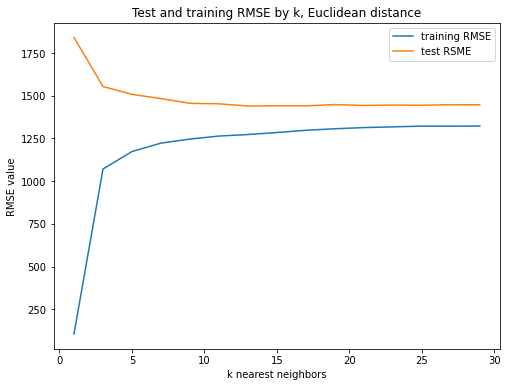

In [80]:
# YOUR CODE HERE
plt.plot(ks, train_rmse, label='training RMSE')
plt.plot(ks, test_rmse, label='test RSME')
plt.legend()
plt.xlabel('k nearest neighbors')
plt.ylabel('RMSE value')
plt.title("Test and training RMSE by k, Euclidean distance");

### Comments

_In the markup cell below, write about what you learned from your plot.  I would expect two or three sentences, but what's most important is that you write something thoughtful._

From just the plot above, I can clearly see that the test RMSE is much lower than the baseline RMSE, which is a good sign; however, because the difference in the Y value is so big, it's hard to see the details for the plotted test RMSE values. The general consensus is that the RMSE dramatically drops for the test data between 1 and 3, and gruadually gets smaller until around 15 k nearest neighbors before it plateaus.

## Impact of distance metric

_Repeat what you did to test the impact of k, but this time use Manhattan distance as your distance metric.  Look at the options for KNeighborsRegressor() to see how to use Manhattan distance._

In [81]:
# YOUR CODE HERE
test_rmse = []
train_rmse = []
ks = np.arange(1, n+1, 2)
for k in ks:
    print(k, ' ', end='')
    regr = KNeighborsRegressor(n_neighbors=k, algorithm='brute', p=1)
    rmse_tr, rmse_te = get_train_test_rmse(regr, X_train, X_test, y_train, y_test)
    train_rmse.append(rmse_tr)
    test_rmse.append(rmse_te)
print('done')

1  3  5  7  9  11  13  15  17  19  21  23  25  27  29  done


_Print the value of k that gives the best test RMSE, and the test RMSE associated with that k, just as you did in the previous section._

In [82]:
# YOUR CODE HERE
best_k, best_rmse = get_best(ks, test_rmse)
print('best k = {}, best test RMSE: {:0.1f}'.format(best_k, best_rmse))

best k = 13, best test RMSE: 1438.5


_Plot the training and test RMSE as a function of k, just as you did in the previous section.  Be sure to note that Manhattan distance was used in your plot title._

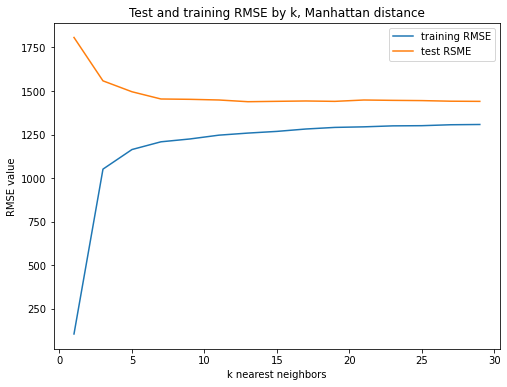

In [83]:
# YOUR CODE HERE
plt.plot(ks, train_rmse, label='training RMSE')
plt.plot(ks, test_rmse, label='test RSME')
plt.legend()
plt.xlabel('k nearest neighbors')
plt.ylabel('RMSE value')
plt.title("Test and training RMSE by k, Manhattan distance");

### Comments

_Consider what you learned from your experiment, and write a little about it.  Think about how the results changed as a result of changing the distance function._

Based on the graphs, there are very little differences between using Euclidean and Manhattan distances for the test data that I used. I do notice that the sharp decline in test RMSE in the beginning is broken into two sections that last until about 8 k nearest neighbors for Manhattan distance, whereas with Euclidean distance, the RMSE value gradually declines starting at about 3. The difference is so little to me that I almost thought I didn't change the power parameter for the Minkowski metric until I checked the best test RMSE values.

## Impact of noise predictors

_In class we heard that the KNN performance goes down if useless "noisy predictors" are present.  These are predictor that don't help in making predictions.  In this section, run KNN regression by adding one noise predictor to the data, then 2 noise predictors, then three, and then four.  For each, compute the training and test RMSE.  In every case, use k=10 as the k value and use Euclidean distance as the distance function._

_The add_noise_predictor() method makes it easy to add a predictor variable of random values to X_train or X_test._

In [66]:
def add_noise_predictor(X):
    """ add a column of random values to 2D array X """
    noise = np.random.normal(size=(X.shape[0], 1))
    return np.hstack((X, noise))

_Hint: In each iteration of your loop, add a noisy predictor to both X_train and X_test.  You don't need to worry about rescaling the data, as the new noisy predictor is already scaled.  Don't modify X_train and X_test however, as you will be using them again._

In [67]:
# YOUR CODE HERE
# for noise predictor from 1-4,
train_temp = X_train
test_temp = X_test
train_rmse = []
test_rmse = []
for i in range(5):
    print(i, ' ', end='')
    knn = KNeighborsRegressor(n_neighbors=k, algorithm='brute', p=1)
    rmse_tr, rmse_te = get_train_test_rmse(knn, train_temp, test_temp, y_train, y_test)
    train_rmse.append(rmse_tr)
    test_rmse.append(rmse_te)
    train_temp = add_noise_predictor(train_temp)
    test_temp = add_noise_predictor(test_temp) 
#   compute test and training rmse (k=10, euclidean distance)
print('done')

0  1  2  3  4  done


_Plot the percent increase in test RMSE as a function of the number of noise predictors.  The x axis will range from 0 to 4.  The y axis will show a percent increase in test RMSE._

_To compute percent increase in RMSE for n noise predictors, compute 100 * (rmse - base_rmse)/base_rmse, where base_rmse is the test RMSE with no noise predictors, and rmse is the test RMSE when n noise predictors have been added._

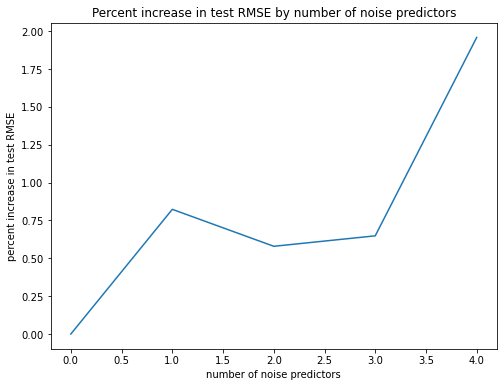

In [68]:
# YOUR CODE HERE
plt.plot(range(5), 100*((test_rmse-test_rmse[0])/test_rmse[0]), label='test RSME')
plt.xlabel('number of noise predictors')
plt.ylabel('percent increase in test RMSE')
plt.title("Percent increase in test RMSE by number of noise predictors");

### Comments

_Look at the results you obtained and add some thoughtful commentary._

To be completely honest, I'm not sure I did this part correctly. It seems like having one noise predictor is slightly owrse than having 2 or 3 noise predictors, but if there are 4 noise predictors, then the RMSE almost triples.

## Impact of scaling

_In class we learned that we should scaled the training data before using KNN.  How important is scaling with KNN?  Repeat the experiments you ran before (like in the impact of distance metric section), but this time use unscaled data._

_Run KNN as before but use the unscaled version of the data.  You will vary k as before.  Use algorithm='brute' and Euclidean distance._

In [73]:
# YOUR CODE HERE
n = 30
test_rmse = []
train_rmse = []
ks = np.arange(1, n+1, 2)
for k in ks:
    print(k, ' ', end='')
    regr = KNeighborsRegressor(n_neighbors=k, algorithm='brute')
    rmse_tr, rmse_te = get_train_test_rmse(regr, X_train_raw, X_test_raw, y_train, y_test)
    train_rmse.append(rmse_tr)
    test_rmse.append(rmse_te)
print('done')

1  3  5  7  9  11  13  15  17  19  21  23  25  27  29  done


_Print the best k and the test RMSE associated with the best k._

In [74]:
# YOUR CODE HERE
best_k, best_rmse = get_best(ks, test_rmse)
print('best k = {}, best test RMSE: {:0.1f}'.format(best_k, best_rmse))

best k = 9, best test RMSE: 1469.2


_Plot training and test RMSE as a function of k.  Your plot title should note the use of unscaled data._

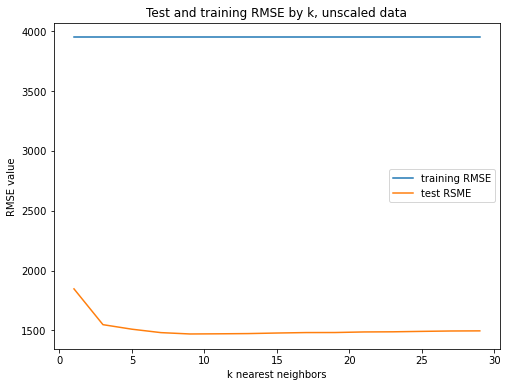

In [75]:
# YOUR CODE HERE
plt.plot(ks, train_rmse, label='training RMSE')
plt.plot(ks, test_rmse, label='test RSME')
plt.legend()
plt.xlabel('k nearest neighbors')
plt.ylabel('RMSE value')
plt.title("Test and training RMSE by k, unscaled data");

### Comments

_Reflect on what happened and provide some short commentary, as in previous sections._

Again, it's hard to see the minute changes in the test RMSE from the graph above because the training RMSE is much higher, thus making the graph more zoomed out. 

## Impact of algorithm

_We didn't discuss in class that there are variants of the KNN algorithm.  The main purpose of the variants is to be faster and to reduce that amount of training data that needs to be stored._

_Run experiments where you test each of the three KNN algorithms supported by Scikit-Learn: ball_tree, kd_tree, and brute.  In each case, use k=10 and use Euclidean distance._

In [ ]:
# YOUR CODE HERE

_Print the name of the best algorith, and the test RMSE achieved with the best algorithm._

In [ ]:
# YOUR CODE HERE

_Plot the test RMSE for each of the three algorithms as a bar plot._

In [ ]:
# YOUR CODE HERE

### Comments

_As usual, reflect on the results and add comments._

YOUR TEXT HERE

## Impact of weighting

_It was briefly mentioned in lecture that there is a variant of KNN in which training points are given more weight when they are closer to the point for which a prediction is to be made.  The 'weight' parameter of KNeighborsRegressor() has two possible values: 'uniform' and 'distance'.  Uniform is the basic algorithm._

_Run an experiment similar to the previous one.  Compute the test RMSE for uniform and distance weighting.  Using k = 10, the brute algorithm, and Euclidean distance._

In [ ]:
# YOUR CODE HERE

_Print the weighting the gave the lowest test RMSE, and the test RMSE it achieved._

In [ ]:
# YOUR CODE HERE

_Create a bar plot showing the test RMSE for the uniform and distance weighting options._

In [ ]:
# YOUR CODE HERE

### Comments

_As usual, reflect and comment._

YOUR TEXT HERE

## Conclusions

_Please provide at least a few sentences of commentary on the main things you've learned from the experiments you've run._

YOUR TEXT HERE